# Genomics Meetup Notebook

This notebook contains some code to try to predict tumor drug sensitivity based on various gene mutation and amplification features.

See this [Genomics Data Challenge](http://www.meetup.com/Charleston-Data-Analytics/messages/boards/thread/49216989) page for more details.

In [1]:
%matplotlib inline
%load_ext rpy2.ipython
repo = 'https://raw.githubusercontent.com/guester/Charleston-Data-Analytics-Cancer-Genomics-Data-Challenge/master/'

In [36]:
from sklearn.preprocessing import StandardScaler
# These are the fields in the raw data that will NOT be used as predictors
non_features = ['tumorID', 'res_AUC', 'res_IC50', 'response', 'type']
response = 'response'

# Create a single scaler instance to use repeatedly
scaler = StandardScaler()

# Data Loading

This function will take care of downloading the raw data from the github repo and caching it locally for faster reloading:

In [3]:
import os
import pickle
def fetch(url):
    fpath = '/Users/eczech/data/meetups/genomics/cache/genomics_analytics_{}.pkl'.format(url.split('/')[-1])
    d = None
    if os.path.exists(fpath):
        d = pd.read_pickle(fpath)
    else:
        d = pd.read_csv(url)
        d.to_pickle(fpath)
        
    # Drop any columns that are exclusively NA
    d = d.dropna(axis=1, how='all')
    
    # Rename non feature columns
    return d.rename(columns={
            'Z_score':'response', 
            'response_metric_IC50':'res_IC50', 
            'response_metric_AUC':'res_AUC',
            'IC50': 'res_IC50'
    })

def fetch_all(file_type):
    d_o = fetch(repo + '{}.csv'.format(file_type))
    d_o['type'] = 'o'
    
    d_h = fetch(repo + 'HCC_{}.csv'.format(file_type))
    d_h['type'] = 'h'
    
    d_c = fetch(repo + 'COSMIC_{}.csv'.format(file_type))
    d_c['type'] = 'c'
    return d_o, d_h, d_c

Load all 3 datasets:

In [4]:
datasets = {
    'cn': {'type': 'numeric'},
    'ge': {'type': 'numeric'},
    'mu': {'type': 'character'}
}

### Load Raw Datasets

In [432]:
d_o_cn, d_h_cn, d_c_cn = fetch_all('copy_number_log2ratios')

In [433]:
d_o_ge, d_h_ge, d_c_ge = fetch_all('gene_expression')

In [434]:
d_o_mu, d_h_mu, d_c_mu = fetch_all('mutations')

### COSMIC Adjustments

Gene expression dataset contains tumors not in the other sets for some reason so remove those:

In [435]:
print(len(d_c_cn), len(d_c_mu), len(d_c_ge))
bad_ids = set(list(d_c_mu.tumorID) + list(d_c_cn.tumorID))
bad_ids = set(d_c_ge.tumorID) - bad_ids 
d_c_ge = d_c_ge[~d_c_ge.tumorID.isin(bad_ids)]
print('Removed {} unknown tumors'.format(len(bad_ids)))
print(len(d_c_cn), len(d_c_mu), len(d_c_ge))

366 366 400
Removed 34 unknown tumors
366 366 366


For some reason, the IC50 values for gene expression in the COSMIC datasets is different than CN and MU.  Correct that here:

In [436]:
res_map = dict(zip(d_c_mu['tumorID'], d_c_mu['res_IC50']))
d_c_ge['res_IC50'] = d_c_ge['tumorID'].apply(lambda x: res_map[x]) # Throws an error if a tumor ID is not present

### Merge Raw Datasets

In [437]:
def merge(d_o, d_h, d_c, na_thresh=10):
    d_m = d_o.append(d_h)
    
    if na_thresh is not None:
        n_ct = d_m.apply(lambda x: x.isnull().sum() if x.name not in non_features else 0)
        print('Frequency of null counts after merge for original data: ')
        print(n_ct.value_counts())
    
    # Remove any records for shared tumors
    #d_c = d_c[~d_c['tumorID'].isin(d_m['tumorID'].unique())] # prefer old data
    d_m = d_m[~d_m['tumorID'].isin(d_c['tumorID'].unique())] # prefer new data
    
    d_m = d_m.append(d_c)
    if na_thresh is not None:
        n_ct = d_m.apply(lambda x: x.isnull().sum() if x.name not in non_features else 0)
        print('Frequency of null counts after merge with COSMIC data: ')
        print(n_ct.value_counts())
        
        print('Removing cols with more than 10 null values')
        cols = n_ct[n_ct <= 10].index.values
        return d_m[cols]

    return d_m

### Copy Number

In [575]:
datasets['cn']['data'] = merge(d_o_cn, d_h_cn, d_c_cn)
datasets['cn']['data'].info()

Frequency of null counts after merge for original data: 
5    19615
0        5
dtype: int64
Frequency of null counts after merge with COSMIC data: 
5      18402
135     4914
371     1213
0          5
dtype: int64
Removing cols with more than 10 null values
<class 'pandas.core.frame.DataFrame'>
Int64Index: 501 entries, 4 to 365
Columns: 18407 entries, A1BG to type
dtypes: float64(18402), object(5)
memory usage: 70.4+ MB


### Gene Expression

In [576]:
datasets['ge']['data'] = merge(d_o_ge, d_h_ge, d_c_ge)
datasets['ge']['data'].info()

Frequency of null counts after merge for original data: 
5    16059
0        5
dtype: int64
Frequency of null counts after merge with COSMIC data: 
5      15655
135      404
371      404
0          5
dtype: int64
Removing cols with more than 10 null values
<class 'pandas.core.frame.DataFrame'>
Int64Index: 501 entries, 4 to 399
Columns: 15660 entries, A1BG to type
dtypes: float64(15655), object(5)
memory usage: 59.9+ MB


### Mutations

In [577]:
datasets['mu']['data'] = merge(d_o_mu, d_h_mu, d_c_mu, na_thresh=None)
datasets['mu']['data'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501 entries, 4 to 365
Columns: 1957 entries, AAK1 to type
dtypes: object(1957)
memory usage: 7.5+ MB


In [581]:
# dt = datasets['ge']['data']
# answers[answers['tumorID'].isin(dt[(dt['type'] == 'c') & (dt['tumorID'].isin(answers.tumorID))].tumorID)]

Fill in missing responses:

In [582]:
answers = fetch(repo + 'answer_key_all_samples.csv')

def resolve_missing_response(d, answers, col):
    m = {r['tumorID']: r[col] for i, r in answers.iterrows()}
    x = []
    for i, r in d[['tumorID', col]].iterrows():
        if not pd.isnull(r[col]) and r[col] != 'hidden':
            x.append(r[col])
        else:
            x.append(m.get(r['tumorID'], r[col]))
    d[col] = np.array(x, dtype=np.float64)

for k in datasets:
    for c in ['res_AUC', 'res_IC50', 'response']:
        resolve_missing_response(datasets[k]['data'], answers, c)

In [583]:
# dt = datasets['cn']['data']
# dt[(dt['type'] == 'c') & (~dt['res_AUC'].isnull())]

In [584]:
# for k in datasets:
#     cols = ['tumorID']
#     rcols = ['response', 'res_AUC', 'res_IC50']
#     print(k)
#     if datasets[k]['type'] == 'numeric':
#         def merge_vals(x):
#             r = x.drop(['tumorID', 'type'], axis=1).apply(np.mean)
#             r['type'] = x['type'].iloc[0] if len(x) == 1 else 'b'
#             return r
#         datasets[k]['data'] = datasets[k]['data'].groupby(cols).apply(merge_vals).reset_index()
#     else:
#         def merge_vals(x):
#             r = x.drop(['tumorID', 'type'], axis=1)
#             r = r[rcols].apply(np.mean).append(r.drop(rcols, axis=1).iloc[0,:])
#             r['type'] = x['type'].iloc[0] if len(x) == 1 else 'b'
#             return r
#         datasets[k]['data'] = datasets[k]['data'].groupby(cols).apply(merge_vals).reset_index()

In [585]:
def all_datasets():
    return [d['data'] for d in datasets.values()]
    
def numeric_datasets():
    return [d['data'] for d in datasets.values() if d['type'] == 'numeric']

In [586]:
def num_unique_tumors(d):
    ct = d.groupby('tumorID').size().value_counts()
    assert len(ct) == 1
    return ct.loc[1]
# Make sure all of these are equal
num_unique_tumors(d_ge), num_unique_tumors(d_cn), num_unique_tumors(d_mu)
assert num_unique_tumors(d_ge) == num_unique_tumors(d_cn) == num_unique_tumors(d_mu)

### Comparing Differences Between COSMIC and others

In [152]:
# # Look at distribution of differences between COSMIC and other data

# d1 = d_o_cn
# d2 = d_c_cn

# d1 = d1[d1['response'] != 'hidden'].set_index('tumorID').drop(['res_AUC', 'res_IC50'], axis=1).stack().reset_index()
# d1.columns = ['tumorID', 'feat', 'val']
# d1['val'] = d1['val'].astype(np.float64)
# d2 = d2.set_index('tumorID').drop(['IC50'], axis=1).stack().reset_index()
# d2.columns = ['tumorID', 'feat', 'val']
# dm = pd.merge(d1, d2, on=['tumorID', 'feat'])
# ax = dm.groupby('feat').apply(lambda x: (x['val_x'] - x['val_y']).mean()).hist()
# ax.set_yscale('symlog')

In [153]:
# dm[dm['feat'] == 'response'].plot(kind='scatter', x='val_x', y='val_y')

In [154]:
# tid = 'A375'
# s1 = d_o_cn[d_o_cn.tumorID == tid].drop(['tumorID', 'res_AUC', 'res_IC50', 'response'], axis=1).stack()
# s1 = s1.reset_index().drop('level_0', axis=1).rename(columns={'level_1': 'feat', 0: 'val'})
# s2 = d_c_cn[d_c_cn.tumorID == tid].drop(['tumorID', 'IC50', 'response'], axis=1).stack()
# s2 = s2.reset_index().drop('level_0', axis=1).rename(columns={'level_1': 'feat', 0: 'val'})
# sm = pd.merge(s1, s2, on='feat', how='outer')
# sm = sm.dropna()
# sm.plot(kind='scatter', x='val_x', y='val_y', figsize=(4,4))

In [155]:
# s1 = d_o_ge.tumorID.unique()
# s2 = d_c_ge.tumorID.unique()
# 'Intersection = {}, Only in original = {}, Only in cosmic = {}'\
#     .format(len(np.intersect1d(s1, s2)), len(np.setdiff1d(s1, s2)), len(np.setdiff1d(s2, s1)))

# Data Validation

Verify that no raw datasets contain non-feature values that the others do not:

In [298]:
x = datasets['ge']['data'].sort('tumorID').iloc[61]['res_IC50']
y = datasets['cn']['data'].sort('tumorID').iloc[61]['res_IC50']
x, y

(4.178121, nan)

In [299]:
tid = 'A101D'
d1 = datasets['cn']['data']
d1 = d1[d1['tumorID'] == tid]
d2 = datasets['ge']['data']
d2 = d2[d2['tumorID'] == tid]
d1['response'].iloc[0], d2['response'].iloc[0]

(-0.087981370558841296, -0.090464143540150893)

Look at differences in response values across different COSMIC datasets.  These should be the same, they were for the old datasets, but they're not for some reason:

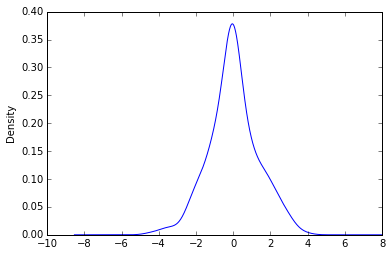

In [417]:
#var = 'res_IC50'
var = 'response'
# cn and mu have same res_IC50 
# they all have different response
v1 = 'mu'
v2 = 'ge'
x = pd.DataFrame({
        'mu': d_c_mu.sort('tumorID')[var], 
        'ge': d_c_ge.sort('tumorID')[var], 
        'cn': d_c_cn.sort('tumorID')[var]}
)
(x[v1] - x[v2]).plot(kind='kde')
#(x[v1] - x[v2]).value_counts()

In [587]:
def validate_equality(col, datasets):
    d = pd.DataFrame({k:datasets[k]['data'].sort('tumorID')[col].values for k in datasets})
    
    idx_cols = ['tumorID', 'type']
    idx = datasets[list(datasets.keys())[0]]['data'].sort('tumorID')[idx_cols]
    d[idx_cols] = idx.reset_index(drop=True)
    d = d.set_index(idx_cols)
    
    d = d.dropna(how='all')
    assert len(d) > 0
    equals = d.apply(lambda x: len(np.unique(x)) == 1, axis=1)
    if not np.all(equals):
        print(d[~equals])
        raise ValueError('Found differing values in raw datasets for column {}'.format(col))

#for col in non_features:
# Ignoring 'response' for now becuase it is different across all 3 datasets
# for new COSMIC tables
for col in ['tumorID', 'res_AUC', 'res_IC50']:
    validate_equality(col, datasets)

Find the tumor cases where all the numeric features from one of the numeric sets (d_cn_r or d_ge_r) are NA.  

At TOW, there were 4 cases where BOTH numeric data sets were all NA and 2 cases where one or the other was NA:

In [588]:
na_cases = []
for d in numeric_datasets():
    na_ct = d.set_index(non_features).apply(lambda x: np.sum(pd.isnull(x))/len(x), axis=1)
    print(na_ct[na_ct > 0])
    na_cases.extend(na_ct[na_ct > .9].reset_index()['tumorID'])
na_cases = list(np.unique(na_cases))
na_cases

tumorID  res_AUC  res_IC50  response   type
COLO699  4.54310  NaN        0.119643  o       1
HCC1359  6.38300  NaN        1.204162  o       1
HCC1833  4.01730  NaN       -0.190287  o       1
HCC2108  5.97710  NaN        0.964906  o       1
T3M10    0.86683  NaN       -2.047313  o       1
dtype: float64
tumorID   res_AUC  res_IC50  response   type
HCC1359   6.38300  NaN        1.204162  o       1
HCC1833   4.01730  NaN       -0.190287  o       1
HCC2108   5.97710  NaN        0.964906  o       1
NCIH2073  4.06880  NaN       -0.159930  o       1
T3M10     0.86683  NaN       -2.047313  o       1
dtype: float64


['COLO699', 'HCC1359', 'HCC1833', 'HCC2108', 'NCIH2073', 'T3M10']

In [108]:
# def get_na_fraction(d):
#     return d.set_index(non_features)\
#         .apply(lambda x: np.sum(pd.isnull(x))/len(x), axis=1)
# null_frac = pd.concat([get_na_fraction(d) for d in numeric_datasets()], axis=1)
# null_frac['avg'] = null_frac.mean(axis=1)
# null_frac.sort('avg', ascending=False).head(10)
# null_frac.head()

# # Verify below that the 'avg' column is either 1 or 0
# # If it is something in between, then extra logic will need to be added to
# # deal with the situation where numeric datasets are "mostly" not null

0   1
tumorID res_AUC res_IC50 response  type        
A101D   NaN     2.138380 -0.087981 c    NaN NaN
                         -0.090464 c    NaN NaN
A172    NaN     5.187349  1.189666 c    NaN NaN
                          1.191499 c    NaN NaN
A204    NaN     3.752764  0.588514 c    NaN NaN

In [122]:
# na_cases = null_frac[(null_frac[0] > .999) | (null_frac[1] > .999)].reset_index()['tumorID']
# na_cases

# Data Preparation

Now that we're sure that no data will be lost in a join on a non-feature column, merge all the raw datasets together and split them into training and holdout sets (based on whether or not the response is equal to 'hidden'):

In [620]:
# Merge all data on non-feature index

join_features = ['tumorID', 'res_AUC', 'res_IC50', 'type']
data = pd.concat([
    datasets[k]['data']\
        .drop('response', axis=1)\
        .set_index(join_features)\
        .rename(columns=lambda c: ':'.join([k, c])) \
    for k in datasets.keys()], 
    axis=1
).reset_index()

# Remove rows with all NA's in one of the numeric datasets (computed above)
data = data[~data['tumorID'].isin(na_cases)]


In [621]:
# dt = data
# dt[(dt['type'] == 'c') & (~dt['res_AUC'].isnull())]

In [622]:
len(data), len(datasets['cn']['data']), len(datasets['ge']['data']), len(datasets['mu']['data'])

(495, 501, 501, 501)

In [549]:
# data['cn:response', 'mu:response', 'ge:response']

In [548]:
data[join_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495 entries, 0 to 500
Data columns (total 4 columns):
tumorID     495 non-null object
res_AUC     135 non-null float64
res_IC50    374 non-null float64
type        495 non-null object
dtypes: float64(2), object(2)
memory usage: 19.3+ KB


### Create Overall Response Value

In [623]:

# Calculate mean and std for each sensitivity measurement type, 
# where present (and also grouped by data source type)
mean_ic50 = data.groupby('type')['res_IC50'].mean().dropna().to_dict()
std_ic50 = data.groupby('type')['res_IC50'].std().dropna().to_dict()
mean_auc = data.groupby('type')['res_AUC'].mean().dropna().to_dict()
std_auc = data.groupby('type')['res_AUC'].std().dropna().to_dict()

def compute_response(x):
    t = x['type']
    # Return nan if this type has no response values
    if not t in mean_ic50 and not t in mean_auc:
        return np.nan
    
    # Make sure at least one response value is not null
    if pd.isnull(x['res_AUC']) and pd.isnull(x['res_IC50']):
        raise ValueError('AUC and IC50 are null')
        
    # Prefer IC50 if both response values are present
    if not pd.isnull(x['res_IC50']):
        return (x['res_IC50'] - mean_ic50[t]) / std_ic50[t]
    return (x['res_AUC'] - mean_auc[t]) / std_auc[t]

# Compute the overall response by switching on where AUC or IC50 is present
data['response'] = data.apply(compute_response, axis=1).values

Examine distributions of responses and values used to create responses:

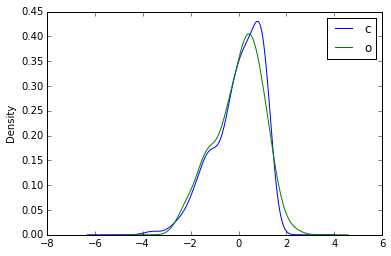

In [624]:
for k, grp in data.groupby('type'):
    if len(grp['response'].dropna()) == 0:
        continue
    grp['response'].plot(kind='kde', label=k, legend=True)

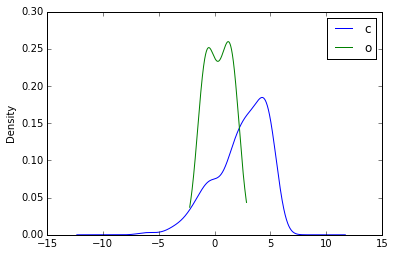

In [625]:
for k, grp in data.groupby('type'):
    if len(grp['res_IC50'].dropna()) == 0:
        continue
    grp['res_IC50'].plot(kind='kde', label=k, legend=True)

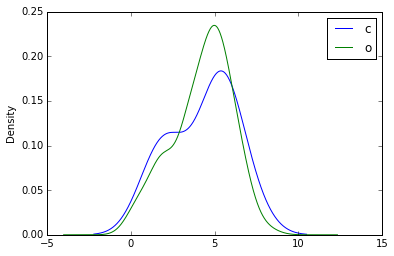

In [626]:
for k, grp in data.groupby('type'):
    if len(grp['res_AUC'].dropna()) == 0:
        continue
    grp['res_AUC'].plot(kind='kde', label=k, legend=True)

# Create Holdout Set

In [627]:
n_ho = 30
np.random.seed(123) # Make sure the random selection is the same each time
idx = np.random.permutation(np.arange(0, len(data)))[:n_ho]
mask = np.array([True if i in idx else False for i in range(len(data))])
data['is_ho'] = True
data['is_ho'] = data['is_ho'].where(mask, np.repeat(False, len(data)))

In [628]:
data['is_ho'].value_counts()

False    465
True      30
dtype: int64

In [629]:
# Randomly assign 12 new cases to the hold out set, that aren't already in it
# idx = pd.Series(np.arange(0, len(data)))[~data['is_ho'].values].values
# np.random.seed(123) # Make sure the random selection is the same each time
# idx = np.random.permutation(idx)[:12]
# new_ho = data['is_ho'].copy()
# new_ho.iloc[idx] = True
# data['is_ho'] = new_ho
# data['is_ho'].value_counts() # Should now be 15 cases where is_ho == True

In [630]:
data.head()

,tumorID,res_AUC,res_IC50,type,cn:A1BG,cn:A1CF,cn:A2M,cn:A2ML1,cn:A4GALT,cn:A4GNT,...,ge:ZWILCH,ge:ZWINT,ge:ZXDC,ge:ZYG11A,ge:ZYG11B,ge:ZYX,ge:ZZEF1,ge:ZZZ3,response,is_ho
0,AMO1,7.1835,NaN,o,0.1540,-0.2066,0.356800,0.356800,-0.2340,0.10170,...,-0.4759,0.3082,-0.7262,1.8097,-1.8718,-1.2941,0.8220,-1.3928,1.666203,False
1,BL70,5.1900,NaN,o,-0.0474,-0.0369,-0.016200,-0.016200,0.0061,-0.01819,...,2.0108,0.4501,1.1429,-1.1830,-1.1503,-1.5781,1.8143,1.3070,0.535292,False
2,C2BBE1,5.1650,NaN,o,0.0481,0.9257,0.362000,0.362000,-0.1787,0.03810,...,-0.2131,1.1403,-0.2701,0.3613,-0.1758,1.2259,-1.7602,-3.0451,0.521109,False
3,CALU3,3.0088,NaN,o,0.3349,0.1454,-0.009054,-0.009054,0.1193,0.73610,...,0.1517,0.7018,0.9007,-0.9018,-1.4952,-0.1633,-1.3113,-0.0842,-0.702101,False
4,CALU6,3.0762,NaN,o,0.2393,0.2413,0.436800,0.436800,-0.4056,0.14220,...,1.2962,-0.1922,-0.7649,-0.5098,-1.5750,-0.0347,0.8514,-0.0573,-0.663865,False


In [631]:
# Split into training and holdout
data_ho, data_tr = data[data.is_ho], data[~data.is_ho]
len(data_ho), len(data_tr)

(30, 465)

### Response Validation 

Verify that the given Z score (as column 'response') actually comes close to what you would get by doing the standardization across the two response metric types yourself:

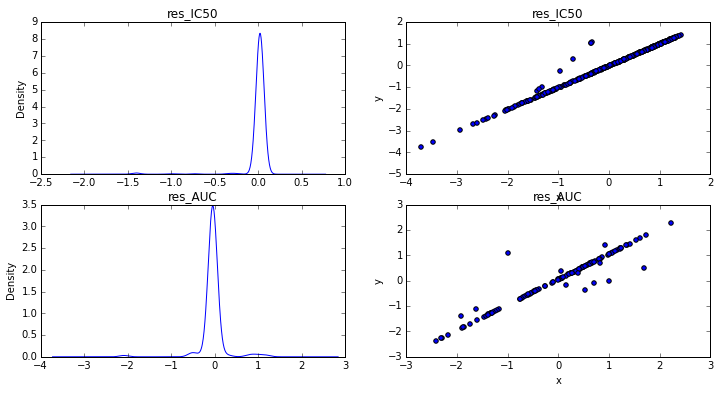

In [632]:
fig, g = plt.subplots(nrows=2, ncols=2); g = iter(g.ravel())
fig.set_size_inches((12, 6))
for col in ['res_IC50', 'res_AUC']:
    dt = data_tr[~data_tr[col].isnull()]
    d1 = scaler.fit_transform(dt[col].astype(np.float64))
    d2 = dt['response'].astype(np.float64)
    pd.Series(d1 - d2).plot(kind='kde', ax=next(g), title=col)
    pd.DataFrame({'x': d1, 'y': d2}).plot(kind='scatter', x='x', y='y', ax=next(g), title=col)
    
# Conclusion: There seems to be something of a bias in the way the z-score for 
# res_AUC was standardized (perhaps the holdout sets just randomly had higher values on average).

### Scaling and Encoding

In [633]:
import re
regex = re.compile('\w|-')

def clean_string(x):
    return ''.join(regex.findall(x.replace('_', '-')))
                   
def encode_strings(d, c):
    feats = []
    for v in d[c]:
        if pd.isnull(v):
            feats.append({})
            continue
        vals = v.split(',')
        feats.append({c+':'+clean_string(val):1 for val in vals})
    return pd.DataFrame(feats)
        
# d = pd.DataFrame({'MU1': [np.nan, 'XY', 'XY,Z,M'], 'MU2': [np.nan, np.nan, 'XY,Z']})
# r = {}
# r.update(encode_strings(d, 'MU1'))
# r.update(encode_strings(d, 'MU2'))
# pd.DataFrame(r).fillna(0).apply(lambda x: x.astype(np.int64)).info()

In [634]:
import re
def prep_data(d):
    regex = re.compile('\w|-')
    res = {}
    for c in d.columns.tolist():
        # If the column is a string, create a dummy encoding for the column
        # that includes NA but then uses NA as the reference level (by dropping it)
        if (d[c].dtype == np.object):
            feats = []
            for v in d[c]:
                if pd.isnull(v):
                    feats.append({})
                    continue
                vals = v.split(',')
                feats.append({c+':'+clean_string(val):1 for val in vals})
            feats = pd.DataFrame(feats).fillna(0).apply(lambda x: x.astype(np.int64))
            for feat in feats:
                assert feat not in res, 'Key "{}" already exists in result'.format(feat)
                res[feat] = feats[feat].values
            #if feats.apply(lambda x : x.sum()).sum() > 0:
                #print(feats.apply(lambda x : x.sum()).sum())
            
        
        # If the column is a float, assure that it is always present and apply standardization
        elif (d[c].dtype == np.float64):
            assert not np.any(d[c].isnull()), 'Found NA values for column {}'.format(c)
            assert c not in res, 'Key "{}" already exists in result'.format(c)
            res[c] = scaler.fit_transform(d[c])
            
        else:
            raise ValueError('Data type "{}" for column "{}" is not yet supported'.format(d[c].dtype, c))
    res = pd.DataFrame(res).fillna(0)
    res.index = d.index
    return res

In [635]:
idx_features = non_features + ['is_ho']
data_ho_prep = prep_data(data_ho.set_index(idx_features))
data_tr_prep = prep_data(data_tr.set_index(idx_features))

data_all = data_ho_prep.append(data_tr_prep).reset_index()

# Determine which mutation features are present less than 3 times and drop them
drop_cols = [c for c in data_all if c.startswith('mu:')]
min_occurrences = 3
drop_cols = data_all[drop_cols].apply(lambda x: x.fillna(0).sum() < min_occurrences)
drop_cols = drop_cols[drop_cols].index.values
data_all = data_all.drop(drop_cols, axis=1)

data_ho_prep = data_all[data_all['is_ho']].set_index(idx_features).fillna(0)
data_tr_prep = data_all[~data_all['is_ho']].set_index(idx_features).fillna(0)
del data_all

In [636]:
data_tr_prep.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465 entries, (AMO1, 7.1835, nan, 1.66620290411, o, False) to (ZR7530, nan, 3.909673, 0.643066544893, c, False)
Columns: 34565 entries, cn:A1BG to mu:ZSCAN31:E320Kfs4
dtypes: float64(34402), int64(163)
memory usage: 122.6+ MB


In [637]:
cols = [c for c in data_tr_prep if c.startswith('mu:')]
data_tr_prep[cols].mean().order(ascending=False).head()

mu:NOTCH4:L16del              0.109677
mu:NCOA3:Q1274-Q1276del       0.094624
mu:FZD1:P93dup                0.086022
mu:PCDH12:S1179-S1181dup      0.083871
mu:KIAA2018:Q1476-Q1478del    0.081720
dtype: float64

# Save Training Data 

Write training data to csv for DataRobot

In [638]:
dt = data_tr_prep.reset_index()
data_export = dt.drop(['tumorID', 'res_AUC', 'res_IC50', 'is_ho', 'type'], axis=1)
#data_export = dt.drop(['tumorID', 'res_AUC', 'res_IC50', 'is_ho', 'type'], axis=1)

#cols = [c for c in data_export if c == 'response' or c.startswith('cn:') or c.startswith('ge:')]
#data_export[cols].to_csv('/Users/eczech/data/meetups/genomics/data.csv', index=False)
#data_export.to_csv('/Users/eczech/data/meetups/genomics/data_v2.csv', index=False)

### Feature Selection

Unfortunately, using all the features with DataRobot isn't possible so some have to be removed:

In [641]:
from sklearn.ensemble import ExtraTreesRegressor
X, y = data_export[[c for c in data_export if c != 'response']], data_export['response']
selector = ExtraTreesRegressor(max_depth=17, max_features=.1, min_samples_leaf=2, n_estimators=2500, n_jobs=-1)
data_export_small = selector.fit_transform(X, y)
feat_imp = pd.Series(selector.feature_importances_, index=X.columns)
print(feat_imp.max())
feat_imp = feat_imp[feat_imp > feat_imp.mean()]
data_export_small = pd.DataFrame(data_export_small, columns=feat_imp.index.values)
data_export_small['response'] = y.values

0.0101723399494


In [783]:
subset_feats = [c for c in data_export_small if c != 'response']
len(subset_feats)

7986

In [642]:
data_export_small.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 465 entries, 0 to 464
Columns: 7987 entries, cn:AADAT to response
dtypes: float64(7987)
memory usage: 28.3 MB


In [643]:
data_export_small.to_csv('/Users/eczech/data/meetups/genomics/data_subset_combined.csv', index=False)

In [734]:
#feat = 'ge:AKAP3'
#feat = 'mu:CPAMD8:H1052Ifs127'
#feat = 'ge:SCOC'
#feat = 'ge:MCL1'
#feat = 'ge:EPHA2'
feats = ['ge:IGSF9B', 'mu:KRAS:G13D', 'ge:EPHA2', 'ge:YAP1', 'ge:AKAP3', 'ge:CCND1']
dt = data_tr_prep.reset_index()
dt = dt[['tumorID', 'response', 'type'] + feats]

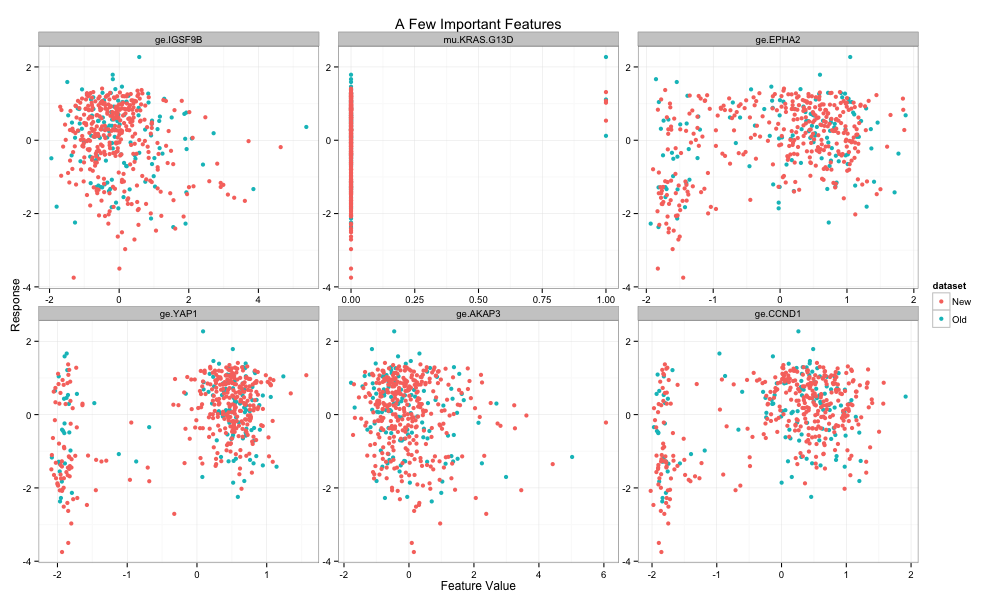

In [738]:
%%R -i dt -w 1000 -h 600 -u px
library(dplyr)
library(ggplot2)
library(reshape2)


dt <- dt %>% melt(id.vars=c('tumorID', 'type', 'response'))
dt$value = as.numeric(dt$value)
dt %>% mutate(dataset=ifelse(type == 'c', 'New', 'Old')) %>% 
    ggplot(aes(x=as.numeric(value), y=response, color=dataset)) + 
        geom_point() + facet_wrap(~variable, scales='free') + theme_bw() + 
        xlab('Feature Value') + ylab('Response') + ggtitle('A Few Important Features')

In [645]:
data_ho_prep.head()

,,,,,,cn:A1BG,cn:A1CF,cn:A2M,cn:A2ML1,cn:A4GALT,cn:A4GNT,cn:AAAS,cn:AACS,cn:AACSP1,cn:AADAC,...,mu:YEATS2:G814del,mu:ZFHX3:A3407Lfs78,mu:ZFHX3:Q1740-Q1741del,mu:ZFHX4:P2048del,mu:ZFHX4:P2057Hfs26,mu:ZMYM2:K1044Rfs33,mu:ZMYM2:N1250Ifs3,mu:ZNF217:P823L,mu:ZNF717:L46Pfs24,mu:ZSCAN31:E320Kfs4
tumorID,res_AUC,res_IC50,response,type,is_ho,,,,,,,,,,,,,,,,,,,,,
CAOV3,4.6915,NaN,0.252493,o,True,2.037850,1.139629,1.089179,1.247675,1.104779,2.099233,1.051304,0.587356,1.017178,0.147116,...,0,0,0,0,0,0,0,0,0,0
CL40,4.0669,NaN,-0.101842,o,True,-0.362893,-0.091711,1.463360,1.658034,0.084264,-1.142005,1.705585,1.388091,-0.026608,-0.886860,...,0,0,0,0,0,0,0,0,0,0
CORL51,1.3704,NaN,-1.631564,o,True,0.107365,0.264345,0.333194,0.418598,-0.255225,1.750557,0.205595,-0.255046,-1.971489,1.141168,...,0,0,0,0,0,0,0,0,0,0
HEC251,4.2839,NaN,0.021262,o,True,-0.287119,-0.125735,-0.404893,-0.390853,-3.568232,1.138209,-0.153570,-0.407506,0.009006,1.799626,...,0,0,0,0,0,0,0,0,0,0
HEC6,4.0177,NaN,-0.129753,o,True,-0.762583,-0.462623,-0.675006,-0.687082,0.829776,-1.214629,-0.648382,-0.932716,0.053687,0.016061,...,0,0,0,0,0,0,0,0,0,0


## Export Holdout Data

In [646]:
ho_export = data_ho_prep.copy()
ho_export.index = pd.Int64Index(np.arange(len(ho_export)))
ho_export[subset_feats].to_csv('/Users/eczech/data/meetups/genomics/data_ho_combined.csv', index=False)

In [647]:
data_ho_prep.head()

,,,,,,cn:A1BG,cn:A1CF,cn:A2M,cn:A2ML1,cn:A4GALT,cn:A4GNT,cn:AAAS,cn:AACS,cn:AACSP1,cn:AADAC,...,mu:YEATS2:G814del,mu:ZFHX3:A3407Lfs78,mu:ZFHX3:Q1740-Q1741del,mu:ZFHX4:P2048del,mu:ZFHX4:P2057Hfs26,mu:ZMYM2:K1044Rfs33,mu:ZMYM2:N1250Ifs3,mu:ZNF217:P823L,mu:ZNF717:L46Pfs24,mu:ZSCAN31:E320Kfs4
tumorID,res_AUC,res_IC50,response,type,is_ho,,,,,,,,,,,,,,,,,,,,,
CAOV3,4.6915,NaN,0.252493,o,True,2.037850,1.139629,1.089179,1.247675,1.104779,2.099233,1.051304,0.587356,1.017178,0.147116,...,0,0,0,0,0,0,0,0,0,0
CL40,4.0669,NaN,-0.101842,o,True,-0.362893,-0.091711,1.463360,1.658034,0.084264,-1.142005,1.705585,1.388091,-0.026608,-0.886860,...,0,0,0,0,0,0,0,0,0,0
CORL51,1.3704,NaN,-1.631564,o,True,0.107365,0.264345,0.333194,0.418598,-0.255225,1.750557,0.205595,-0.255046,-1.971489,1.141168,...,0,0,0,0,0,0,0,0,0,0
HEC251,4.2839,NaN,0.021262,o,True,-0.287119,-0.125735,-0.404893,-0.390853,-3.568232,1.138209,-0.153570,-0.407506,0.009006,1.799626,...,0,0,0,0,0,0,0,0,0,0
HEC6,4.0177,NaN,-0.129753,o,True,-0.762583,-0.462623,-0.675006,-0.687082,0.829776,-1.214629,-0.648382,-0.932716,0.053687,0.016061,...,0,0,0,0,0,0,0,0,0,0


### DataRobot predictions on holdout
This was for original datset minus COSMIC values

    RowId	Prediction
    1	-0.211582788
    2	0.379920062
    3	-0.033066266

## Export All Subset Data

In [787]:
export = data_tr_prep.append(data_ho_prep)[subset_feats].reset_index()
f = '/Users/eczech/repos/misc/Charleston-Data-Analytics-Cancer-Genomics-Data-Challenge/modeling/data'
export.to_csv(f + '/data_prep_ho_n_30.csv', index=False)

# Analyzing Holdout Results

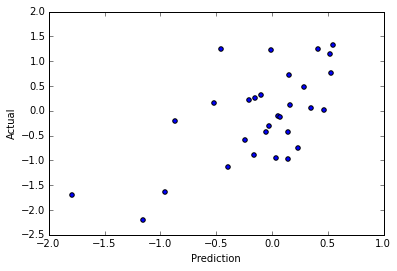

In [655]:
ho_pred = pd.read_csv('/Users/eczech/data/meetups/genomics/data_ho_pred_combined.csv')
ho_pred[['tumorID', 'Actual']] = data_ho_prep.reset_index()[['tumorID', 'response']]
ho_pred.head()
#ho_pred.plot(kind='scatter', x='Prediction', y='Actual')

# Modeling

In [656]:
from ml.model import models, common, importances
import imp
imp.reload(common)
imp.reload(models)
imp.reload(importances)

<module 'ml.model.importances' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/model/importances.py'>

In [657]:
data_tr_prep.head()

,,,,,,cn:A1BG,cn:A1CF,cn:A2M,cn:A2ML1,cn:A4GALT,cn:A4GNT,cn:AAAS,cn:AACS,cn:AACSP1,cn:AADAC,...,mu:YEATS2:G814del,mu:ZFHX3:A3407Lfs78,mu:ZFHX3:Q1740-Q1741del,mu:ZFHX4:P2048del,mu:ZFHX4:P2057Hfs26,mu:ZMYM2:K1044Rfs33,mu:ZMYM2:N1250Ifs3,mu:ZNF217:P823L,mu:ZNF717:L46Pfs24,mu:ZSCAN31:E320Kfs4
tumorID,res_AUC,res_IC50,response,type,is_ho,,,,,,,,,,,,,,,,,,,,,
AMO1,7.1835,NaN,1.666203,o,False,0.324516,-0.420408,0.919092,0.915749,-0.268402,-0.152704,1.242831,-0.880984,0.378247,-0.258598,...,0,0,0,0,0,0,0,0,0,0
BL70,5.1900,NaN,0.535292,o,False,-0.249883,0.080166,-0.081715,-0.083144,0.446310,-0.565257,-0.375855,-0.118297,-0.237740,-0.533235,...,0,0,0,0,0,0,0,0,0,0
C2BBE1,5.1650,NaN,0.521109,o,False,0.022486,2.919599,0.933044,0.929675,-0.103789,-0.371557,-0.394657,-0.303552,0.070400,-0.273500,...,0,0,0,0,0,0,0,0,0,0
CALU3,3.0088,NaN,-0.702101,o,False,0.840448,0.617906,-0.062542,-0.064008,0.783275,2.030329,-2.232388,1.081694,0.889266,1.804071,...,0,0,0,0,0,0,0,0,0,0
CALU6,3.0762,NaN,-0.663865,o,False,0.567794,0.900787,1.133742,1.129989,-0.779208,-0.013339,0.375746,0.297407,0.299448,0.039450,...,0,0,0,0,0,0,0,0,0,0


In [658]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNetCV, ElasticNet, Lasso, LassoCV

Run 5 different model types over fairly small grids (still takes 2 hours even on all cores):

In [744]:
clf = RandomForestRegressor()

feats = [c for c in data_export_small if c != 'response']
X, y = data_export_small[feats], data_export_small['response']

clf.fit(X, y)

X_ho = data_ho_prep[feats]
y_ho = clf.predict(X_ho)

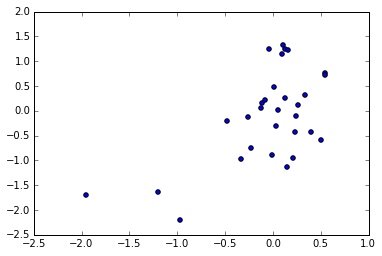

In [745]:
#plt.scatter(y_ho, data_ho_prep.reset_index()['response'])

In [761]:
??SVR

In [3]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import KFold
from sklearn.svm import SVR
from sklearn.linear_model import RidgeCV
features = data_tr_prep.columns.tolist()

n = 500
X, y = data_tr_prep[features].head(n), data_tr_prep.reset_index()['response'].head(n)

gbr_grid = {
    'n_estimators': [1, 100, 1000],
    'learning_rate': [.001, .01, .1, 1],
    'min_samples_leaf': [1, 2, 5],
    'max_depth': [1, 5, 13]
}
rf_grid = {
    'n_estimators': [1, 10, 100, 250],
    'min_samples_leaf': [1, 3],
    'max_depth': [1]
}
etr_grid = {
    'n_estimators': [250],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', .001, .01],
    'max_depth': [None, 3, 17]
}
svr_grid = {
    'C': np.logspace(-1, 2, 6),
    'degree': [3],
    'gamma': np.logspace(-5, -3, 6),
    'kernel': ['rbf'],
    'max_iter': [15000]
}
n_jobs = -1
clfs = {
    #'gbr': RandomizedSearchCV(GradientBoostingRegressor(), gbr_grid, n_iter=30, cv=5, n_jobs=n_jobs),
    #'rf': GridSearchCV(RandomForestRegressor(), rf_grid, cv=5, n_jobs=n_jobs),
    #'etr': ExtraTreesRegressor(),#GridSearchCV(ExtraTreesRegressor(), etr_grid, cv=3, n_jobs=n_jobs),
    #'enet': ElasticNetCV(cv=5, n_jobs=n_jobs, max_iter=10000),
    #'svr': GridSearchCV(SVR(kernel='linear'), svr_grid, cv=5, n_jobs=n_jobs),
    #'lasso': LassoCV(cv=3, n_jobs=n_jobs, max_iter=10000)
    #'rf': RandomForestRegressor()
    #'svr': GridSearchCV(SVR(), svr_grid, cv=5)
    'ridge': RidgeCV()
}

res = models.run_regressors(
    X, y, clfs, KFold(len(y), 10), keep_X=False, 
    par_n_jobs=6, par_verbose=1,
    log_file='/tmp/genomics_cv.log')

NameError: name 'data_tr_prep' is not defined

In [765]:
from ml.model import summaries as ml_precis

In [766]:
ml_precis.summarize_grid_parameters(res)

model_name  variable                        
svr         C         1.5848931924611134         8
                      6.30957344480193           2
            degree    3                         10
            gamma     2.5118864315095822e-05    10
            kernel    rbf                       10
            max_iter  15000                     10
dtype: int64

Take a look at the accuracy between the model types and make sure they're all performing similarly, at least according to MSE:

In [769]:
models.summarize_scores(res, score_func)['score'].mean()

0.78511465051117013

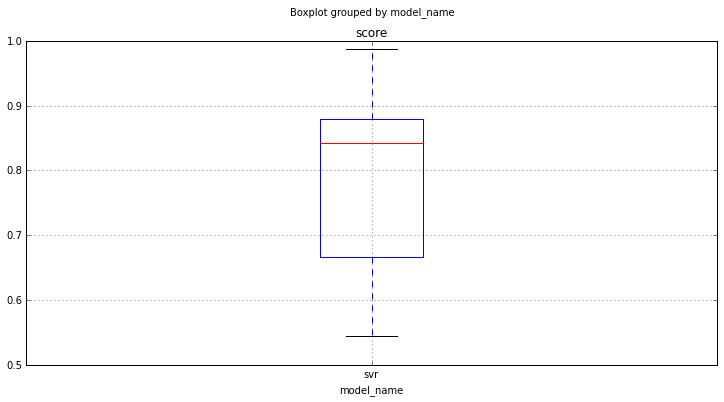

In [767]:
from sklearn.metrics import mean_squared_error
score_func = lambda clf, y_true, y_pred: mean_squared_error(y_true, y_pred)
ml_precis.plot_model_scores(res, score_func)

Plot the most influential features as determined by each model (using the average value across folds):

In [757]:
ml_precis.plot_feature_importance(res)

### Out of Sample Predictions

In [758]:
preds = models.summarize_predictions(res)
preds.head()

,y_pred,y_true,model_name,fold_id
0,0.187933,1.666203,svr,1
1,0.173604,0.535292,svr,1
2,0.209223,0.521109,svr,1
3,0.206434,-0.702101,svr,1
4,0.212163,-0.663865,svr,1


### Plot of predicted response vs actual response

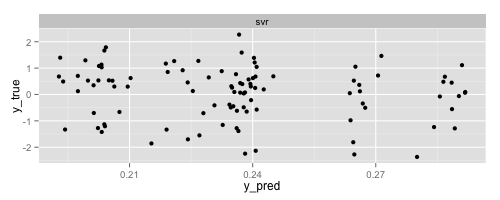

In [752]:
%%R -i preds -w 500 -h 200 -u px
library(ggplot2)
library(dplyr)
preds %>%
    mutate(y_pred=as.numeric(y_pred), y_true=as.numeric(y_true)) %>%
    mutate(fold_id=factor(as.numeric(fold_id))) %>%
    ggplot(aes(x=y_pred, y=y_true)) + geom_point() + facet_wrap(~model_name, nrow=1)

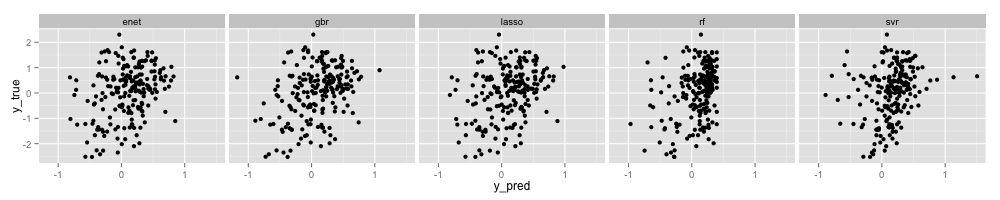

In [71]:
%%R -i preds -w 1000 -h 200 -u px
library(ggplot2)
library(dplyr)
preds %>%
    mutate(y_pred=as.numeric(y_pred), y_true=as.numeric(y_true)) %>%
    mutate(fold_id=factor(as.numeric(fold_id))) %>%
    ggplot(aes(x=y_pred, y=y_true)) + geom_point() + facet_wrap(~model_name, nrow=1)

As the predicted values above (on the x-axis) go up, the actual values tend to go up as well (y-axis) though there is plenty of variation around the predictions.  Overall though, there is definitely some predictive accuracy being gained.

## Comparing Feature Ranks

In [73]:
# Determine the median rank of each feature across all the model types and print the top 15 here
ranked_feats = feat_means.rank(ascending=False).median(axis=1).order()
ranked_feats.head(15)

ge:OXR1         1
ge:THEM4        3
ge:SPINT2      10
ge:C9ORF43     12
ge:RALGPS1     13
ge:TAPT1       16
ge:SHC1        17
ge:PAPSS2      20
ge:RARS        27
ge:ZNF571      28
ge:SEMA4D      28
ge:ETF1        28
ge:KLF3.AS1    31
ge:ZNF354C     32
ge:NTMT1       32
dtype: float64

In [63]:
def get_top_feat_data(feats):
    feat_ranks = {feat:i+1 for i, feat in enumerate(feats)}
    d = data_tr_prep.reset_index()[feats + ['response', 'tumorID']]
    d['response'] = d['response'].astype(np.float64)
    d = pd.melt(d, id_vars=['tumorID', 'response'])
    d['rank'] = d['variable'].map(feat_ranks)
    return d

## Top Features Overall 

At TOW, they were all from the Gene Expression dataset:

In [64]:
plot_data = get_top_feat_data(ranked_feats.index[:24].tolist())
plot_data.head()

,tumorID,response,variable,value,rank
0,A2780,0.434701,ge:OXR1,-0.752222,1
1,AGS,-1.109348,ge:OXR1,-0.993599,1
2,AMO1,1.676012,ge:OXR1,-0.949704,1
3,BEN,-0.313480,ge:OXR1,-1.212011,1
4,BL70,0.500955,ge:OXR1,-0.410166,1


In [65]:
%%R
plot.feats <- function(plot_data){
    plot_data <- plot_data %>%
        mutate(value=as.numeric(value), response=as.numeric(response)) %>%
        mutate(rank=as.integer(rank), variable=paste0(as.character(variable), ' (rank =', rank, ')', sep=''))
    feat_levels <- plot_data %>% group_by(variable) %>% summarise(rank=rank[1]) %>%
        ungroup %>% arrange(rank) %>% .$variable
    plot_data %>%
        mutate(variable=factor(as.character(variable), levels=feat_levels)) %>%
        ggplot(aes(x=value, y=response)) + geom_point() + facet_wrap(~variable, ncol=4) +
        theme_bw()
}

### Plot feature values vs actual response

For the most influential features, this should show that as the response on the x-axis changes, there is some (almost exclusively linear) relationship with the response (y-axis):

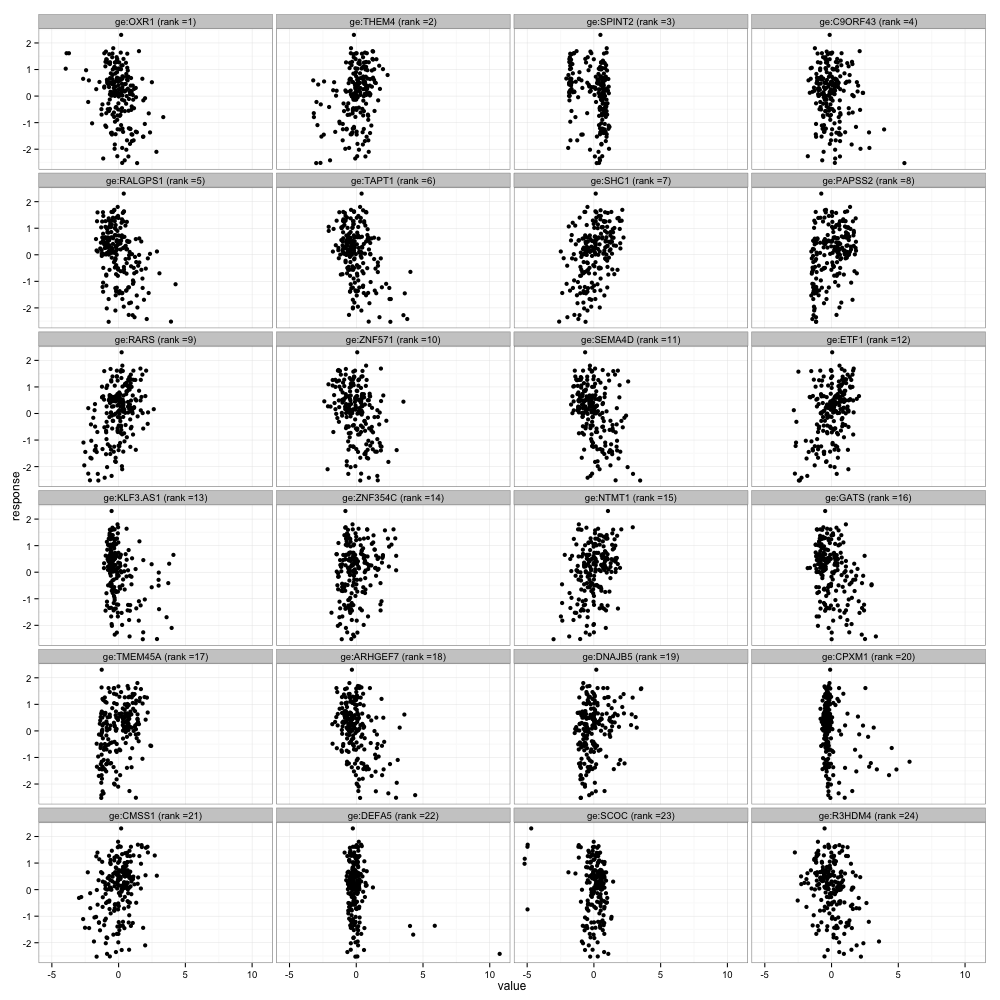

In [66]:
%%R -i plot_data -h 1000 -w 1000 -u px
plot.feats(plot_data)

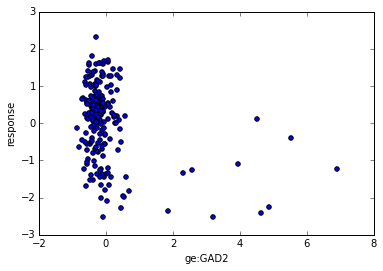

In [126]:
feat = 'ge:GAD2'
dt = data_tr_prep.reset_index()[['response', feat]]
dt = dt.convert_objects(convert_numeric=True)
dt.plot(kind='scatter', x=feat, y='response')


## Top Copy Number Features

Even though the gene expression features were best overall, subset the ranked features to the ones from the Copy Number dataset and check those out as well:

In [67]:
cn_feats = ranked_feats[pd.Series(ranked_feats.index).str.startswith('cn:').values].index.tolist()[:8]
plot_data = get_top_feat_data(cn_feats)
plot_data.head()

,tumorID,response,variable,value,rank
0,A2780,0.434701,cn:MIR548I3,0.621431,1
1,AGS,-1.109348,cn:MIR548I3,0.621431,1
2,AMO1,1.676012,cn:MIR548I3,0.621431,1
3,BEN,-0.313480,cn:MIR548I3,-0.484506,1
4,BL70,0.500955,cn:MIR548I3,0.621431,1


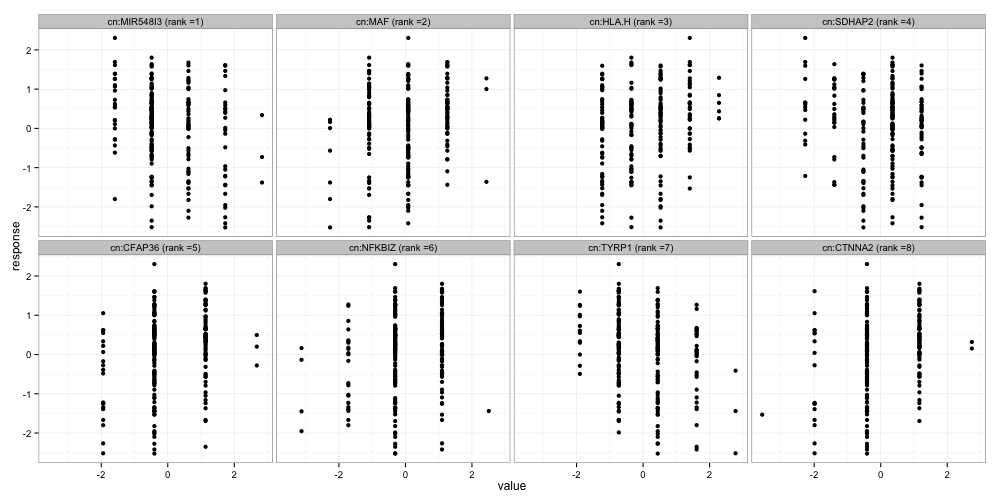

In [68]:
%%R -i plot_data -h 500 -w 1000 -u px
plot.feats(plot_data)

## Top Mutation Features

Same as above, except for the mutations dataset

In [69]:
cn_feats = ranked_feats[pd.Series(ranked_feats.index).str.startswith('mu:').values].index.tolist()[:8]
plot_data = get_top_feat_data(cn_feats)
plot_data.head()

,tumorID,response,variable,value,rank
0,A2780,0.434701,mu:FERD3L:E80dup,0,1
1,AGS,-1.109348,mu:FERD3L:E80dup,0,1
2,AMO1,1.676012,mu:FERD3L:E80dup,0,1
3,BEN,-0.313480,mu:FERD3L:E80dup,0,1
4,BL70,0.500955,mu:FERD3L:E80dup,0,1


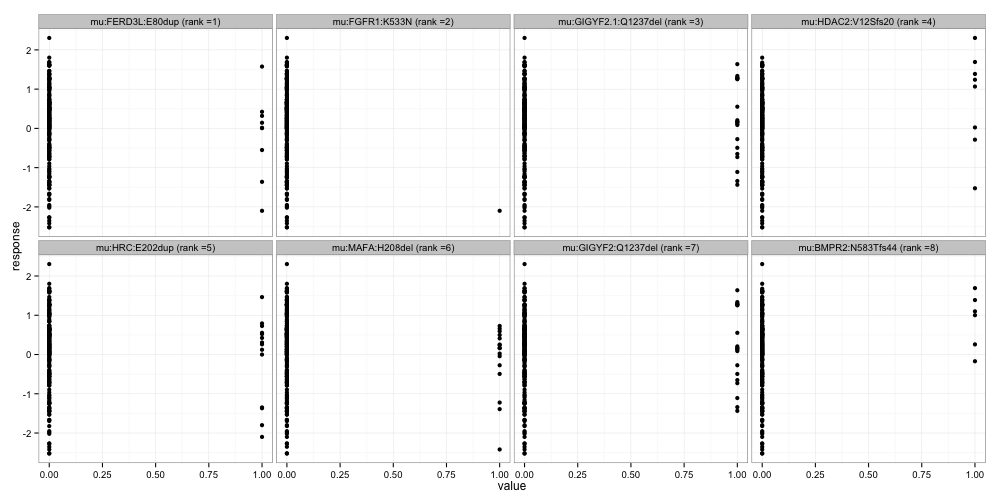

In [70]:
%%R -i plot_data -h 500 -w 1000 -u px
plot.feats(plot_data)

# Scratch

In [102]:
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.cross_validation import KFold, train_test_split

features = data_tr_prep.columns.tolist()
X, y = data_tr_prep[features], data_tr_prep.reset_index()['response'].astype(np.float64)

n_estimators = 2000
gbr_grid = {
    'n_estimators': [n_estimators],
    'learning_rate': [.001, .01, .1, 1],
    'max_features': [.0001, .001, .01],
    'min_samples_leaf': [1, 5],
    'max_depth': [1, 3, 5]
}
clf = RandomizedSearchCV(GradientBoostingRegressor(), gbr_grid, n_iter=25, n_jobs=-1, cv=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             random_state=None, subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=25, n_jobs=-1,
          param_distributions={'max_depth': [1, 3, 5], 'max_features': [0.0001, 0.001, 0.01], 'min_samples_leaf': [1, 5], 'learning_rate': [0.001, 0.01, 0.1, 1], 'n_estimators': [2000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=None, verbose=0)

In [103]:
clf.best_params_

{'learning_rate': 0.01,
 'max_depth': 3,
 'max_features': 0.0001,
 'min_samples_leaf': 5,
 'n_estimators': 2000}

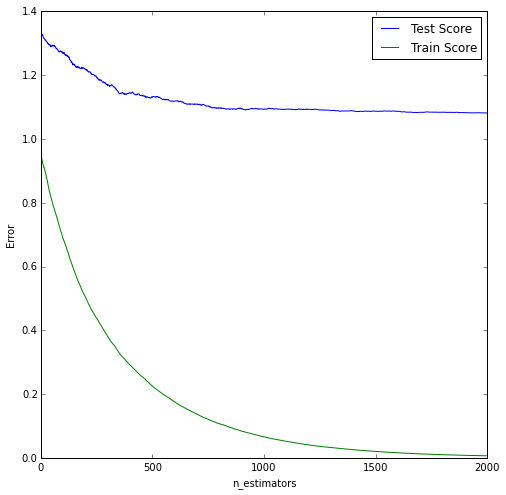

In [104]:
gbr = clf.best_estimator_
test_dev = np.empty(n_estimators)
for i, pred in enumerate(gbr.staged_predict(X_test)):
    test_dev[i] = gbr.loss_(y_test, pred)
    
ax = pd.DataFrame({
        'Train Score': gbr.train_score_, 
        'Test Score': test_dev}, 
        index=np.arange(n_estimators) + 1).plot(figsize=(8,8))
ax.set_ylabel('Error')
ax.set_xlabel('n_estimators')